# CNN

Os códigos aqui foram baseados no livro Hands-On Machine Learning with Sickit Learning, Keras and TensorFlow e a organização foi retirada desse repositório no [github](https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb) 


## SETUP

In [ ]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## O que é uma Convolução?

Aqui são carregadas imagens de amostra, criados 2 filtros e plotando a imagem com os filtros criados. Os dados carregados são normalizados (divisão por 255) para obter valores flutuantes que variam de 0 a 1.

Mostrando a imagem com os filtros aplicados e a original, respectivamente.

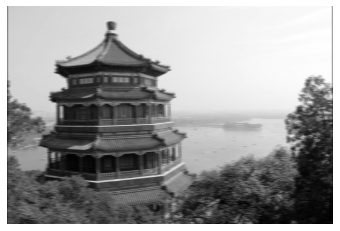

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Carregamento dos dados
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Criação de 2 filtros ou convultional kernel
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # Linha vertical
filters[3, :, :, 1] = 1  # Linha horizontal

# Função da api do keras que aplica filtros(filters) em tensor's de entrada (images) com stride (passos usado no padding)  
# vertical e horizontal e padding que pode ser "SAME" que usa zero no padding se necessário, e "VALID" que não usa zero 
# e que pode ignorar algumas linhas e colunas.
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # Plotando a 1º imagem e o 2º feature map.
plt.axis("off")
plt.show()

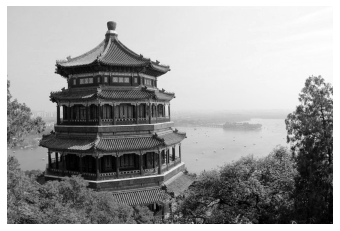

In [ ]:
plt.imshow(images[0, :, :, 1], cmap="gray") # Plotando imagem original
plt.axis("off")
plt.show()

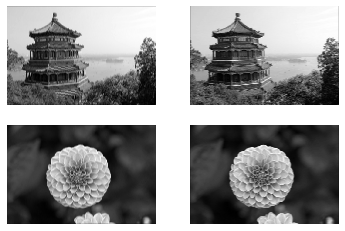

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Mostrando os feature maps verticais e horizontais, e plot das matrizes de feature map. Neurônios que usam os pesos de um filtro vertical irão ignorar seus campos receptivos exceto aqueles com a posição central na linha vertical. O mesmo ocorre para o filtro horizontal.


In [ ]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


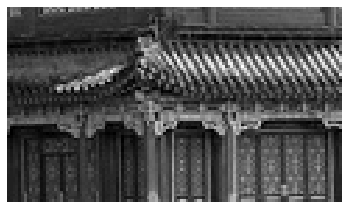

Saving figure china_vertical


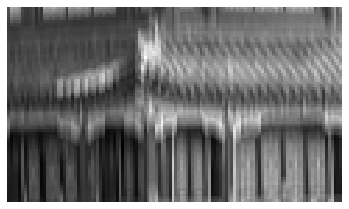

Saving figure china_horizontal


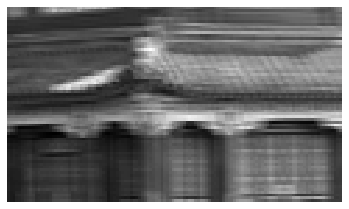

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

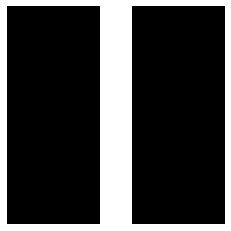

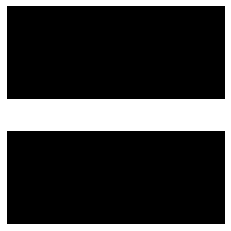

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Camada convulacional

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

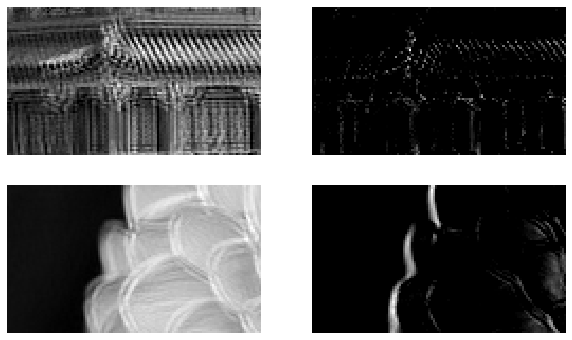

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [ ]:
conv.set_weights([filters, np.zeros(2)])

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

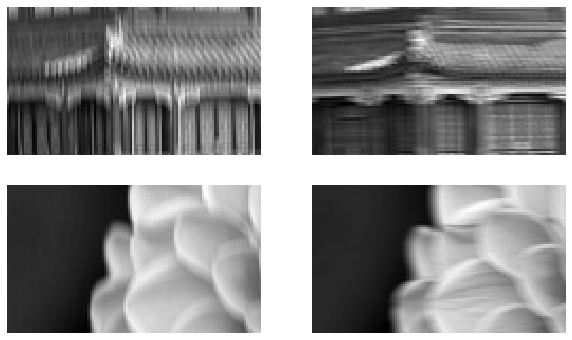

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## Max Pooling

Com o objetivo de de obter uma subasmotra da imagem de entrada para reduzir a carga computacional, uso de memória e o número de parâmetros (limitando o risco de overfitting)

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


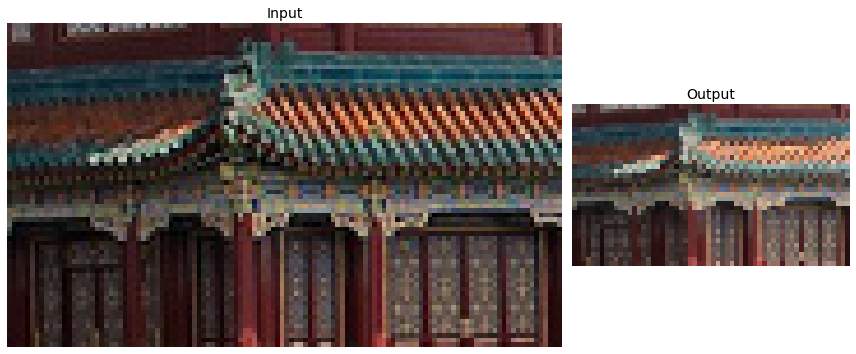

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Averaging Pooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

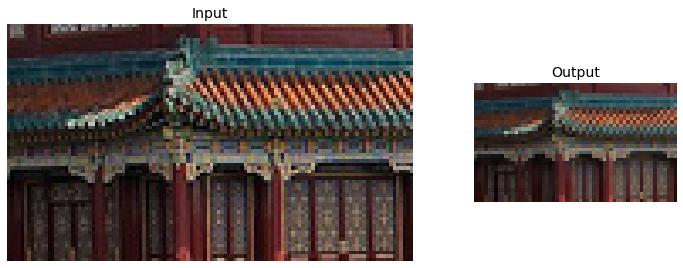

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Usando CNN no MNIST

Carregando os dados mnist, normalizando, dividindo os conjuntos de treino, teste e validação.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    #1 - A primeira camada  usa 64 filtros, setando sua entrada para  para 28x28x1 já que são imagens de 28 x 28 pixels  e apenas um canal de cor (cinza).
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),

    #2 - Em seguida uma camada de max pooling de tamanho igual a 2, dividindo cada dimensão por 2.
    keras.layers.MaxPooling2D(pool_size=2),

    #3 - A mesma estrutura é repetida duas vezes, isto é, duas camadas convulacionais e 1 camada de MaxPooling. Os filtros vão aumentando conforme as camadas são empilhadas
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    
    #4 - Por fim, uma camada fully connected, composta de duas densas camadas ocultas e uma camada densa de saída. As camadas de dropout existem  para diminuir o risco de overfitting
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(units=10, activation='softmax'),
])

PS: Apesar das características da imagem (pequenos círculos, linhas horizontais) serem bem pequenas dimensionalmente, é possível combiná-las de várias formas, por isso os filtros vão aumentando em 3. É uma prática comum dobrar o núemro de filtros após uma camada de Pooling.

PS 2: Uma camada de Flatten é aplicada nas entradas pois uma rede densa expera um array de 1 dimensão.



In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 18s 9ms/step - loss: 0.7019 - accuracy: 0.7553 - val_loss: 0.3676 - val_accuracy: 0.8678
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4135 - accuracy: 0.8609 - val_loss: 0.3397 - val_accuracy: 0.8808
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3561 - accuracy: 0.8801 - val_loss: 0.3179 - val_accuracy: 0.8882
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3322 - accuracy: 0.8874 - val_loss: 0.2888 - val_accuracy: 0.8906
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3039 - accuracy: 0.8970 - val_loss: 0.2719 - val_accuracy: 0.8994
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2900 - accuracy: 0.9023 - val_loss: 0.3064 - val_accuracy: 0.8916
Epoch 7/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2702 - accuracy: 0.9064 - val_loss: 0.2732 - val_ac

## Usando um modelo pré-treinado

Normalmente você não irá implementar um dos modelos padrões de arquiteturas como GoogleNet, ResNet.. etc. O Keras fornece algumas implementações. O código abaixo criará um modelo ResNet-50 e fará o download dos pesos pré-treinados em uma dataset do repositório [ImageNet](https://image-net.org/).

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

ResNet-50 espera imagens de 224 x 224 pixels a célula abaixo faz esse resize nos dados. Mais abaixo é feito um padding na imagem e na última célula é feito um crop e pad para destacar apenas a torre.

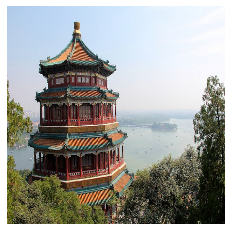

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

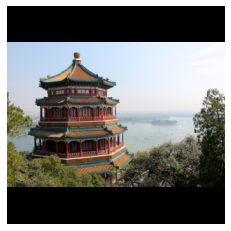

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()

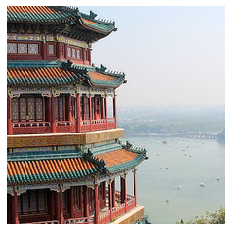

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

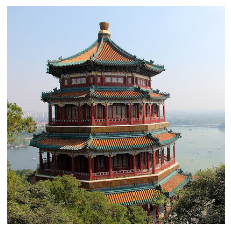

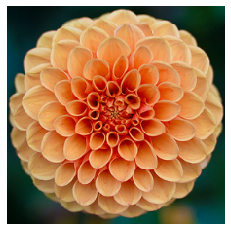

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

Alguns modelos pré-treinados assume que as imagens vão estar em um determinado formato, pré-processadas de uma determinada forma. Normalizadas entre 0 e 1. A célula abaixo "desnormaliza", multiplancando os valores por 255. 

As últimas células mostram a probabilidade de uma imagem pertencer à cada classe.

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

(2, 1000)

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pré-treino para transferência de aprendizagem

Para casos em que se deseja construir um novo modelo para classificação de imagens mas você não possui dados de treinamento suficiente, pode ser uma boa ideia reusar camadas de um modelo pré-treinado. 

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

As células abaixo mostrando as classes de imagens contidas no dataset, o tamanho do dataset.

Em seguida uma divisão de treino e teste é feita e para cada classe é plotada uma imagem referente à classe.

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

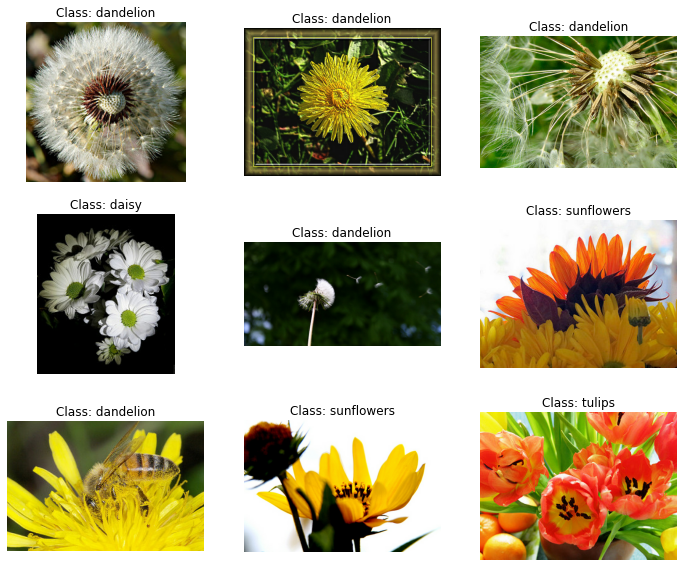

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

**Pré-processamento básico**

Alguns passos de pré-processamento são aplicados aqui. Como mencionado anteriormente, a CNN em questão precisa que as imagens possuam resolução 224 x 224. Passo feito na primeira célula.

In [ ]:
# Essa célula aplica alguns passos de data augmentation, ou seja, são apenas passos de variação dos datasets originais.
# Basicamente são feitas algumas transformações aleatórios, como girar a imagem horizontalmente, recortá-las aleatoriamente e de forma centralizada
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
# O pré-processamento deve ser feito em todos os conjuntos.
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Abaixo é possível visualizar o resultado do pré-processamento dos conjuntos de treino e de teste

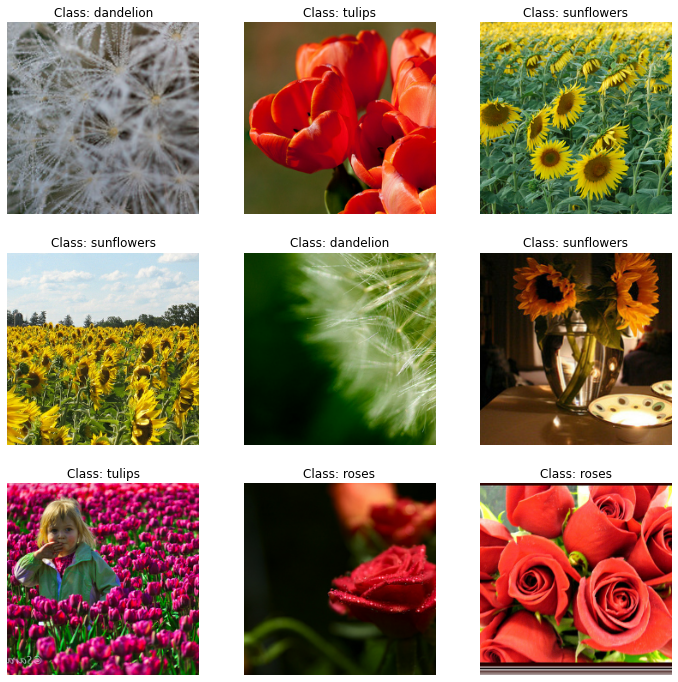

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

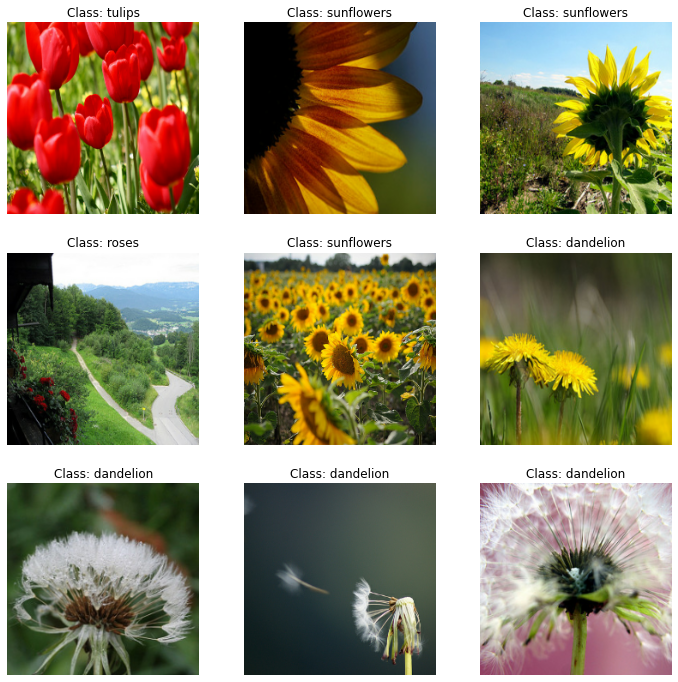

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

1. Uma rede pré-treinada com dados do repositório ImageNet é carregada. O topo da rede é excluído, as camadas de Pooling e densa de saída são excluídas.

2. Uma camadade de Pooling de média global é aplicada à saída do modelo obtido de 1.

3. É aplicada uma camada densa e em 4. o modelo é criado.

Na célula abaixo estão listadas as camadas do modelo pré-treinado.

In [ ]:
# 1 
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# 2
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# 3
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

#4
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_11
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_12
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_13
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6

Como boa prática é interessante "congelar" os pesos das camadas do modelo pré-treinado no início do treinamento.

Por fim é feito o modelo é compilado e treinado.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
86/86 [==============================] - 20s 179ms/step - loss: 1.1694 - accuracy: 0.7998 - val_loss: 1.2447 - val_accuracy: 0.8327
Epoch 2/5
86/86 [==============================] - 15s 175ms/step - loss: 0.4801 - accuracy: 0.8950 - val_loss: 0.7170 - val_accuracy: 0.8787
Epoch 3/5
86/86 [==============================] - 15s 171ms/step - loss: 0.2831 - accuracy: 0.9288 - val_loss: 0.8161 - val_accuracy: 0.8548
Epoch 4/5
86/86 [==============================] - 14s 167ms/step - loss: 0.2048 - accuracy: 0.9390 - val_loss: 0.6601 - val_accuracy: 0.8695
Epoch 5/5
86/86 [==============================] - 14s 165ms/step - loss: 0.1816 - accuracy: 0.9491 - val_loss: 0.6642 - val_accuracy: 0.8768


Como após algumas épocas a acurácia de validação alcançou entre 75~80% e parou de aumentar muito, isso significa que as camadas do topo estão muito bem treinadas, portanto é possível "descongelar" as camadas e continuar o treinamento. 

Passo executado na célula abaixo.


PS: Essa célula pode demorar bastante tempo.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 35s 363ms/step - loss: 0.9270 - accuracy: 0.7522 - val_loss: 2.9755 - val_accuracy: 0.1801
Epoch 2/40
86/86 [==============================] - 30s 353ms/step - loss: 0.3498 - accuracy: 0.8797 - val_loss: 2.6378 - val_accuracy: 0.1801
Epoch 3/40
86/86 [==============================] - 29s 342ms/step - loss: 0.1845 - accuracy: 0.9335 - val_loss: 5.3870 - val_accuracy: 0.2390
Epoch 4/40
86/86 [==============================] - 30s 349ms/step - loss: 0.1593 - accuracy: 0.9382 - val_loss: 3.4309 - val_accuracy: 0.2390
Epoch 5/40
86/86 [==============================] - 30s 348ms/step - loss: 0.0814 - accuracy: 0.9709 - val_loss: 3.1108 - val_accuracy: 0.3015
Epoch 6/40
86/86 [==============================] - 30s 346ms/step - loss: 0.0813 - accuracy: 0.9698 - val_loss: 2.2964 - val_accuracy: 0.3824
Epoch 7/40
86/86 [==============================] - 30s 348ms/step - loss: 0.0540 - accuracy: 0.9804 - val_loss: 1.5147 - val_accuracy: 0.6324

## Classificação e localização

Algo comum na tarefa de localização de um objeto é predizer uma bouding box que define a posição de um determinado objeto. Assim é necessário predizer 4 atributos: coordenadas verticais e horizontais, altura e largura. 

Assim facilmente adicionando uma camada densa com uma saída de 4 unidades, podemos alcançar o resultado esperado.

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)

loc_output = keras.layers.Dense(4)(avg)

model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

O dataset das flores não possui rounding boxes, então é necessário adicioná-los.

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 6s 590ms/step - loss: 1.3284 - dense_4_loss: 1.5660 - dense_5_loss: 0.3779 - dense_4_accuracy: 0.3125 - dense_5_accuracy: 0.2750
Epoch 2/2
5/5 [==============================] - 3s 600ms/step - loss: 1.2806 - dense_4_loss: 1.5193 - dense_5_loss: 0.3258 - dense_4_accuracy: 0.3812 - dense_5_accuracy: 0.2438


## Aumentando a perfomance de uma CNN no MNIST

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


A arquitetura abaixo é uma das melhores para o MNIST, entretanto é possível melhorar a acurácia e alcançar 99.5% a 99.7% no conjunto de teste. Para isso é necessário:
- adicionar uma imagem [augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/); 
- uma normalização em [batch](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
- criar um agendamento de aprendizagem (learning rate annealing, é uma abordagem em que você inicia com uma taxa de aprendizagem muito alta e gradualmente vai diminuindo essa taxa durante o treinamento) 
- e possivelmente criar um [ensemble](https://analyticsindiamag.com/hands-on-guide-to-create-ensemble-of-convolutional-neural-networks/) (basicamente consiste em "agrupar" várias CNN's).

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.1977 - accuracy: 0.9393 - val_loss: 0.0458 - val_accuracy: 0.9882
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0787 - accuracy: 0.9761 - val_loss: 0.0420 - val_accuracy: 0.9882
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0610 - accuracy: 0.9817 - val_loss: 0.0351 - val_accuracy: 0.9908
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0492 - accuracy: 0.9848 - val_loss: 0.0345 - val_accuracy: 0.9910
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.0367 - val_accuracy: 0.9908
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0404 - val_accuracy: 0.9910
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0340 - val_accuracy

[0.02578105218708515, 0.9933000206947327]

Links interessantes:
- https://playground.tensorflow.org/#

Outros assuntos interessantes:
- [Yolo](https://www.kdnuggets.com/2018/09/object-detection-image-classification-yolo.html)
- [Semantic segmentation](https://towardsdatascience.com/semantic-segmentation-with-deep-learning-a-guide-and-code-e52fc8958823)